In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Read in the data set
olympic_data = pd.read_csv('athlete_events.csv')
olympic_data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


**lets do basic things like cleaning and building data quality**

In [6]:
print(olympic_data.isnull().sum())

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64


For height, weight and Age have a lot of missing values. Medals have a NaN in about 2,31,333 rows. These can be explained since not all participating athletes would win medals. Let's replace these missing values by 'Did not win' or 'DNW'

In [7]:
olympic_data['Medal'].fillna('DNW', inplace = True)

In [9]:
print(olympic_data.isnull().sum())

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64


In [11]:
print(olympic_data.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head())

NOC
FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: count, dtype: int64


In [12]:
noc_country = pd.read_csv('noc_regions.csv')
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

noc_country.head()

,NOC,Country
0,AFG,Afghanistan
1,AHO,Curacao
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra


This has to be a left join since we want all participating countries to remain in the data even if their NOC-Country is not found in the master. We can easily correct those manually.

In [13]:
olympics_merge = olympic_data.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

In [14]:
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()

,NOC,Team
578,SGP,Singapore
6267,ROT,Refugee Olympic Athletes
44376,SGP,June Climene
61080,UNK,Unknown
64674,TUV,Tuvalu
80986,SGP,Rika II
108582,SGP,Singapore-2
235895,SGP,Singapore-1


Entering manually for below:
1. SGP - Singapore
2. ROT - Refugee Olympic Athletes
3. UNK - Unknown
4. TUV - Tuvalu

In [15]:
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

**lets try GDP and population**

In [21]:
gdp_w = pd.read_csv('world_gdp.csv', skiprows = 3) # first 3 row not needed

gdp_w.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

gdp_w = pd.melt(gdp_w, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')
# convert the year column to numeric
gdp_w['Year'] = pd.to_numeric(gdp_w['Year'])
gdp_w.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


In [22]:
len(list(set(olympics_merge['NOC'].unique()) - set(gdp_w['Country Code'].unique())))

108

In [24]:
len(list(set(olympics_merge['Team'].unique()) - set(gdp_w['Country Name'].unique())))

6

Lets add a country code for each Team in the olympics dataset first and then merge using the Country Code. The data now has GDP data attached!

In [26]:
# Merge to get country code
olympics_merge_con_code = olympics_merge.merge(gdp_w[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_con_code.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_con_code.merge(gdp_w,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

In [28]:
# Read in the population data
population_world = pd.read_csv('world_pop.csv')

population_world.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

population_world = pd.melt(population_world, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
population_world['Year'] = pd.to_numeric(population_world['Year'])

population_world.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


**lets get completed data with GDP and Population**

In [29]:
olympics_complete = olympics_merge_gdp.merge(population_world,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')
# Using left join
olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark,DNK,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,NLD,2.585680e+11,1.476009e+07


In [30]:
olympics_complete.isnull().sum()

ID                  0
Name                0
Sex                 0
Age              9474
Height          60171
Weight          62875
NOC                 0
Games               0
Year                0
Season              0
City                0
Sport               0
Event               0
Medal               0
Team                0
Country Code     1397
GDP             86925
Population      65120
dtype: int64

 We can see Population and GDP are only for 1961 onwards whereas Olympics data is from 1896. Hence, let's consider **only data from 1961 onwards.**

In [31]:
# Lets take data from 1961 onwards only and for summer olympics only
olympics_complete_req_data = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

# Reset row indices
olympics_complete_req_data = olympics_complete_req_data.reset_index()

**Exploratory Data Analysis for medals**

In [32]:
olympics_complete_req_data['Medal_Won'] = np.where(olympics_complete_req_data.loc[:,'Medal'] == 'DNW', 0, 1)

In [33]:
olympics_complete_req_data.head()

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population,Medal_Won
0,0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09,0
1,1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09,0
2,31,12,Jyri Tapani Aalto,M,31.0,172.0,70.0,FIN,2000 Summer,2000,Summer,Sydney,Badminton,Badminton Men's Singles,DNW,Finland,FIN,1.255400e+11,5.176209e+06,0
3,32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,FIN,1996 Summer,1996,Summer,Atlanta,Sailing,Sailing Women's Windsurfer,DNW,Finland,FIN,1.320990e+11,5.124573e+06,0
4,33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,FIN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Women's Windsurfer,DNW,Finland,FIN,1.255400e+11,5.176209e+06,0


This means that for team events, just a sum of the 'Medal_Won' column would give us an incorrect picture of the medal tally.If a team wins more than one gold medal for an event in an edition of the olympics, then that event is a team event.

In [37]:
# Check whether number of medals won in a year for an event by a team exceeds 1. This indicates a team event.
identify_team_events = pd.pivot_table(olympics_complete_req_data,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

team_sports = identify_team_events['Event'].unique()

#print(team_sports)

After more investigation, I discovered that they are actually single events, but because two athletes had the same score/time, both were awarded the gold medal. We must remove these events from the list of team sports.


In [38]:
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar",
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_sports = list(set(team_sports) - set(remove_sports))

In [39]:
# to diff single and team event idea is if an event name matches with one in team sports, then it is a team event. Others are singles events.
team_event_mask = olympics_complete_req_data['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

# rows where medal_won is 1
medal_mask = olympics_complete_req_data['Medal_Won'] == 1

# Put 1 under team event if medal is won and event in team event list
olympics_complete_req_data['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)

# Put 1 under singles event if medal is won and event not in team event list
olympics_complete_req_data['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)

# Add an identifier for team/single event
olympics_complete_req_data['Event_Category'] = olympics_complete_req_data['Single_Event'] + \
olympics_complete_req_data['Team_Event']

In [40]:
olympics_complete_req_data.head()

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,...,Event,Medal,Team,Country Code,GDP,Population,Medal_Won,Team_Event,Single_Event,Event_Category
0,0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,...,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09,0,0,0,0
1,1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,...,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09,0,0,0,0
2,31,12,Jyri Tapani Aalto,M,31.0,172.0,70.0,FIN,2000 Summer,2000,...,Badminton Men's Singles,DNW,Finland,FIN,1.255400e+11,5.176209e+06,0,0,0,0
3,32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,FIN,1996 Summer,1996,...,Sailing Women's Windsurfer,DNW,Finland,FIN,1.320990e+11,5.124573e+06,0,0,0,0
4,33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,FIN,2000 Summer,2000,...,Sailing Women's Windsurfer,DNW,Finland,FIN,1.255400e+11,5.176209e+06,0,0,0,0


In [41]:
medal_tally_agnostic = olympics_complete_req_data.\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

Lest find out, Who are the best Olympic-playing nations of all time? With the revised statistics, let's look at the total medal count of the top four countries from 1964 to 2016.

In [42]:
# Medal Tally.
medal_tally = medal_tally_agnostic.groupby(['Year','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Team',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:5]

# print total medals won in the given period
medal_tally_pivot.loc[:,'All']

Team
USA        1387.0
Russia     1298.0
Germany    1042.0
China       545.0
Name: All, dtype: float64

Text(0.5, 1.0, 'Olympic Performance Comparison')

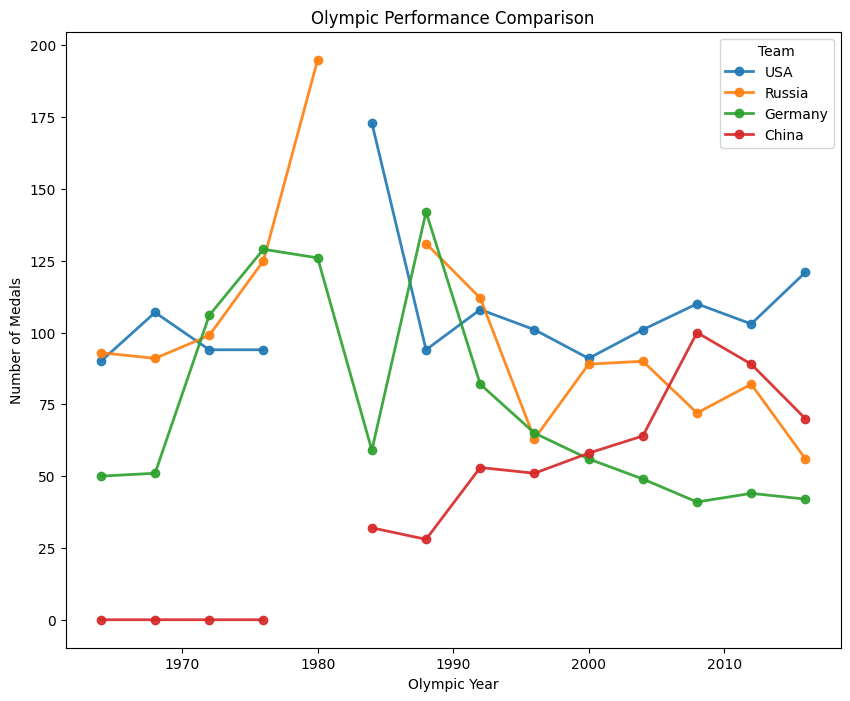

In [43]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

year_team_medals = pd.pivot_table(medal_tally,
                                  index = 'Year',
                                  columns = 'Team',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum')[top_countries]

# plotting the medal tallies
year_team_medals.plot(linestyle = '-', marker = 'o', alpha = 0.9, figsize = (10,8), linewidth = 2)
xlabel('Olympic Year')
ylabel('Number of Medals')
title('Olympic Performance Comparison')

**Explaination of above graph :**
China did not win medal before 1984.

Interesting Insights
 1: The blank values in 1980 for the United States and China are not data errors! To protest the Soviet invasion of Afghanistan in late 1979, the United States launched a boycott of the 1980 Summer Olympics in Moscow. 65 countries refused to participate in the games, but 80 sent athletes to compete, including India.

 2: Russia's lost point in 1984 is also not an error! The boycott of the 1984 Summer Olympics in Los Angeles came four years after the United States-led boycott of the 1980 Summer Olympics in Moscow. The boycott included 14 Eastern Bloc countries and allies, led by the Soviet Union, which launched it on May 8, 1984.

Text(0, 0.5, 'Decided Top Country')

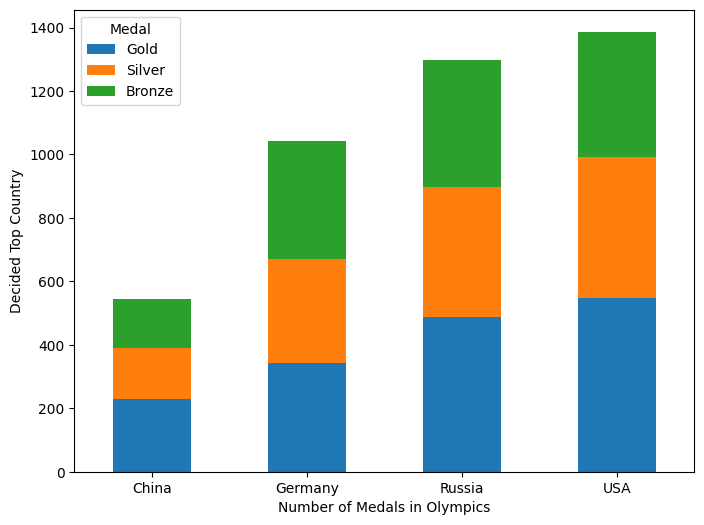

In [46]:

# List of top countries
top_countries_asperdata = ['USA', 'Russia', 'Germany', 'China']

# row mask where countries match
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in top_countries_asperdata)

# Pivot table to calculate sum of gold, silver and bronze medals for each country
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Team'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1)

# Re-order the columns so that they appear in order on the chart.
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
xlabel('Number of Medals in Olympics')
ylabel('Decided Top Country')

####### *Lets try for home hosting and medal wining praportion if time remains -- just an idea* ***just an idea*** ################




In [71]:
olympics_complete_req_data[['Year', 'City']].drop_duplicates().sort_values('Year')
# Correct city names in the dataset
olympics_complete_req_data['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)
# city to country mapping dictionary
city_to_country = {'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Munich': 'Germany',
                  'Montreal': 'Canada',
                  'Moscow': 'Russia',
                  'Los Angeles': 'USA',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Atlanta': 'USA',
                  'Sydney': 'Australia',
                  'Athens': 'Greece',
                  'Beijing': 'China',
                  'London': 'UK',
                  'Rio de Janeiro': 'Brazil'}

# Map cities to countries
olympics_complete_req_data['Country_Host'] = olympics_complete_req_data['City'].map(city_to_country)

#print the
olympics_complete_req_data.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')

,Year,Country_Host
74,1964,Japan
11,1968,Mexico
12,1972,Germany
37,1976,Canada
70,1980,Russia
10,1984,USA
13,1988,South Korea
0,1992,Spain
3,1996,USA
2,2000,Australia


GDP is a proxy for a country's resources. **A higher GDP means more resources to allocate to sports.**

Text(7101223999999.844, 145.0, 'Correlation = 0.6229032997622935')

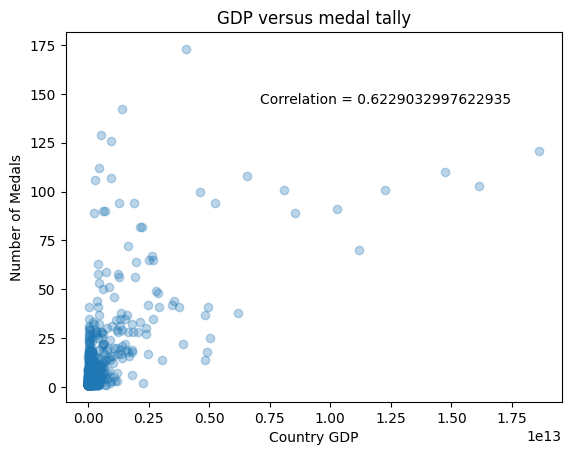

In [72]:
import matplotlib.pyplot as plt

yearteam_gdp = olympics_complete_req_data.loc[:, ['Year', 'Team', 'GDP']].drop_duplicates()

medal_tally_vs_gdp = medal_tally.merge(yearteam_gdp,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   how = 'left')

row_mask_5 = medal_tally_vs_gdp['Medal_Won_Corrected'] > 0
row_mask_6 = medal_tally_vs_gdp['Team'].map(lambda x: x in top_countries)

correlation = medal_tally_vs_gdp.loc[row_mask_5, ['GDP', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]

plot(medal_tally_vs_gdp.loc[row_mask_5, 'GDP'],
     medal_tally_vs_gdp.loc[row_mask_5, 'Medal_Won_Corrected'] ,
     linestyle = 'none',
     marker = 'o',
    alpha = 0.3)
xlabel('Country GDP')

ylabel('Number of Medals')
title('GDP versus medal tally')
text(np.nanpercentile(medal_tally_vs_gdp['GDP'], 99.6),
     max(medal_tally_vs_gdp['Medal_Won_Corrected']) - 50,
     "Correlation = " + str(correlation))

**which country rules which sport ?**

In [73]:
players_sport_medal = olympics_complete_req_data.groupby(['Team','Name', 'Sport'])['Medal_Won'].agg('sum').reset_index()
players_sport_medal.sort_values(['Sport', 'Medal_Won'], ascending = [True, False], inplace = True)

# keep only athletes who won medals

medal_mask = players_sport_medal['Medal_Won'] > 0
players_sport_medal = players_sport_medal[medal_mask]

players_sport_medal.head()

,Team,Name,Sport,Medal_Won
66110,South Korea,Kim Su-Nyeong,Archery,6
65767,South Korea,Ki Bo-Bae,Archery,4
66718,South Korea,Park Seong-Hyeon,Archery,4
16642,China,Zhang Juanjuan,Archery,3
39055,Italy,Marco Galiazzo,Archery,3


lets find greater medal count and sport

In [74]:
# Now lets calculate the number of participations of each athlete. This will be sport wise.
players_sport_appearance = olympics_complete_req_data.groupby(['Team', 'Name', 'Sport'])['NOC'].agg('count').reset_index()

players_sport_appearance.rename(columns = {'NOC': 'Event_Count'}, inplace = True)

#players_sport_appearance.head()
# lets merge these two
players_medal_appearance = players_sport_medal.merge(players_sport_appearance,
                                            left_on = ["Team", "Name", "Sport"],
                                            right_on = ['Team', 'Name', 'Sport'],
                                            how = "left")

# Calculate the medal per participation
players_medal_appearance['Medal_Per_Participation'] = players_medal_appearance['Medal_Won']/players_medal_appearance['Event_Count']

players_medal_appearance.sort_values(['Medal_Per_Participation', 'Medal_Won'], ascending = [False, False], inplace = True)

#players_medal_appearance.head(10)
# filter out athletes with less than 10 total medals.
players_medal_appearance = players_medal_appearance[players_medal_appearance['Medal_Won'] >= 10]

players_medal_appearance

,Team,Name,Sport,Medal_Won,Event_Count,Medal_Per_Participation
12179,USA,Natalie Anne Coughlin (-Hall),Swimming,12,12,1.000000
150,USA,"Frederick Carlton ""Carl"" Lewis",Athletics,10,10,1.000000
4925,Germany,Isabelle Regina Werth,Equestrianism,10,10,1.000000
12184,USA,"Gary Wayne Hall, Jr.",Swimming,10,10,1.000000
12176,USA,"Michael Fred Phelps, II",Swimming,28,30,0.933333
3614,Germany,Birgit Fischer-Schmidt,Canoeing,12,13,0.923077
12177,USA,"Dara Grace Torres (-Hoffman, -Minas)",Swimming,12,13,0.923077
12181,USA,Mark Andrew Spitz,Swimming,11,12,0.916667
12182,USA,"Matthew Nicholas ""Matt"" Biondi",Swimming,11,12,0.916667
12180,USA,Ryan Steven Lochte,Swimming,12,14,0.857143


**Insight : America rules Swimming and Russia rules Gymnastics..!!!!**

Lets try to predict medal for country. We think ,following factors affect a country's medal tally -
GDP
Contingent Size
Population

In [75]:
medal_tally_vs_gdp.head()

,Year,Team,Medal_Won_Corrected,GDP
0,1964,Afghanistan,0.0,8.000000e+08
1,1964,Algeria,0.0,2.909352e+09
2,1964,Argentina,1.0,2.560525e+10
3,1964,Australia,18.0,2.378766e+10
4,1964,Austria,0.0,9.169984e+09


In [76]:
# create the year, team contingent size
year_team_gender = olympics_complete_req_data.loc[:,['Year','Team', 'Name', 'Sex']].drop_duplicates()

year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']
year_team_gender_count = year_team_gender_count.fillna(0)

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

year_team_contingent = year_team_gender_count.loc[:, ['Year', 'Team','Total_Athletes']]
year_team_contingent.head()
# Get year team population
year_team_pop = olympics_complete_req_data.loc[:, ['Year', 'Team', 'Population']].drop_duplicates()
year_team_pop.head()

,Year,Team,Population
0,1992,China,1.164970e+09
1,2012,China,1.350695e+09
2,2000,Finland,5.176209e+06
3,1996,Finland,5.124573e+06
6,2008,Norway,4.768212e+06


In [77]:
# merge all these datasets together
medal_gdpdata_population = medal_tally_vs_gdp.merge(year_team_pop,
                                            left_on = ['Year', 'Team'],
                                            right_on = ['Year', 'Team'],
                                            how = 'left')

medal_gdpdata_pop_contingent = medal_gdpdata_population.merge(year_team_contingent,
                                                     left_on = ['Year', 'Team'],
                                                     right_on = ['Year', 'Team'],
                                                     how = 'left')
medal_gdpdata_pop_contingent.head()

,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes
0,1964,Afghanistan,0.0,8.000000e+08,9731361.0,8.0
1,1964,Algeria,0.0,2.909352e+09,12295970.0,1.0
2,1964,Argentina,1.0,2.560525e+10,21953929.0,102.0
3,1964,Australia,18.0,2.378766e+10,11167000.0,243.0
4,1964,Austria,0.0,9.169984e+09,7223801.0,56.0


In [70]:
olympics_complete_req_data.head()

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,...,Event,Medal,Team,Country Code,GDP,Population,Medal_Won,Team_Event,Single_Event,Event_Category
0,0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,...,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09,0,0,0,0
1,1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,...,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09,0,0,0,0
2,31,12,Jyri Tapani Aalto,M,31.0,172.0,70.0,FIN,2000 Summer,2000,...,Badminton Men's Singles,DNW,Finland,FIN,1.255400e+11,5.176209e+06,0,0,0,0
3,32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,FIN,1996 Summer,1996,...,Sailing Women's Windsurfer,DNW,Finland,FIN,1.320990e+11,5.124573e+06,0,0,0,0
4,33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,FIN,2000 Summer,2000,...,Sailing Women's Windsurfer,DNW,Finland,FIN,1.255400e+11,5.176209e+06,0,0,0,0


In [78]:
# get host nation from the data

year_host = olympics_complete_req_data.loc[:, ['Year', 'Country_Host']].drop_duplicates()

# merge this with the larger dataset
lin_model_data = medal_gdpdata_pop_contingent.merge(year_host,
                              left_on = 'Year',
                              right_on = 'Year',
                              how = 'left')

lin_model_data.head()

,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes,Country_Host
0,1964,Afghanistan,0.0,8.000000e+08,9731361.0,8.0,Japan
1,1964,Algeria,0.0,2.909352e+09,12295970.0,1.0,Japan
2,1964,Argentina,1.0,2.560525e+10,21953929.0,102.0,Japan
3,1964,Australia,18.0,2.378766e+10,11167000.0,243.0,Japan
4,1964,Austria,0.0,9.169984e+09,7223801.0,56.0,Japan


Text(0.5, 1.0, 'Population Distribution')

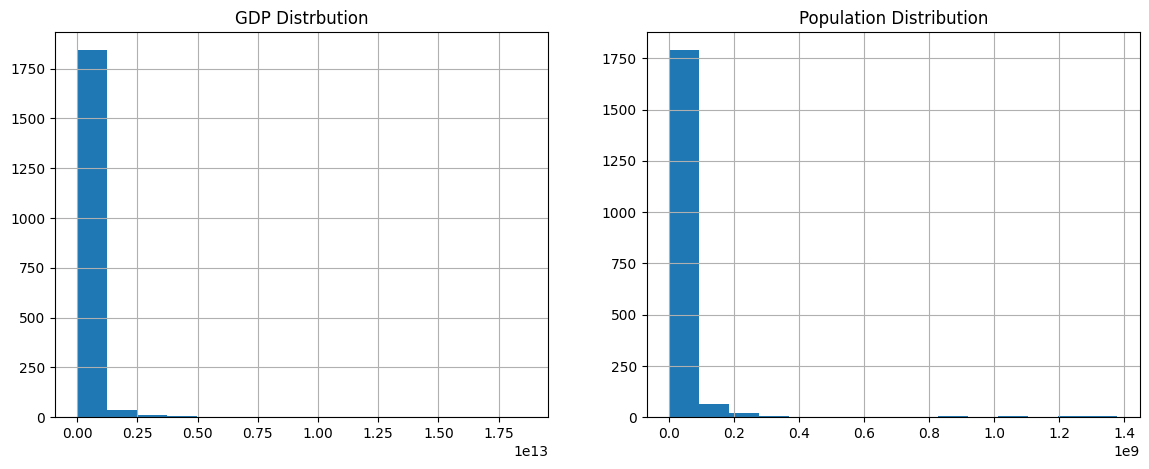

In [80]:
# Regression model
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics
import matplotlib.pyplot as plt

# add indicator to see whether home advantage
lin_model_data['Home_adv'] = np.where(lin_model_data['Country_Host'] == lin_model_data['Team'], 1, 0)

# Add per capita GDP
lin_model_data['GDP_per_capita'] = lin_model_data['GDP']/lin_model_data['Population']

# remove NAs
lin_model_data.dropna(how = 'any', inplace = True)


# Lets see the distrbution of population and GDP in a histogram

fig, (ax1, ax2) = subplots(nrows = 1,
                          ncols = 2,
                          figsize = (14,5))

lin_model_data['GDP'].hist(bins = 15, ax = ax1)
ax1.set_title('GDP Distrbution')

lin_model_data['Population'].hist(bins = 15, ax = ax2)
ax2.set_title('Population Distribution')

Lest try logirathmic regression model for this

In [82]:
import math

# take the log transforms for the variables
lin_model_data['Log_Population'] = np.log(lin_model_data['Population'])
lin_model_data['Log_GDP'] = np.log(lin_model_data['GDP'])

In [83]:
# regression model
y, X = dmatrices('Medal_Won_Corrected ~ Log_GDP + Log_Population + Total_Athletes + Home_adv + GDP_per_capita',
                data = lin_model_data,
                return_type = 'dataframe')

model = sm.OLS(y, X)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Medal_Won_Corrected   R-squared:                       0.755
Model:                             OLS   Adj. R-squared:                  0.754
Method:                  Least Squares   F-statistic:                     1170.
Date:                 Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                         04:15:40   Log-Likelihood:                -6455.3
No. Observations:                 1907   AIC:                         1.292e+04
Df Residuals:                     1901   BIC:                         1.296e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         16.6564      2.214      7.525      0.000      12.315      20.998
Log_GDP           -1.1254      0.161     -7.009      0.000      -1.440      -0.811
Log_Population     0.3971      0.155      2.562      0.010       0.093       0.701
Total_Athletes     0.1462      0.002     58.549      0.000       0.141       0.151
Home_adv          -7.9921      2.180     -3.665      0.000     -12.269      -3.716
GDP_per_capita  1.344e-05   1.48e-05      0.907      0.365   -1.56e-05    4.25e-05
==============================================================================
Omnibus:                     1859.147   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           253485.577
Skew:                           4.229   Prob(JB):                         0.00
Kurtosis:                      58.845   Cond. No.                     2.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The following summary reveals a R-squared value of 0.75, which is good. This suggests that these variables account for 75% of the variation in the medal count.


While 75% is a good R-squared, it's important to consider the amount of error when projecting a country's medal total, which shouldn't be too great. The RMSE error for the forecasts is displayed below:

Using known predictors, a country's medal tally may be predicted with an error of only ~7 medals. That is impressive!

In [84]:
# what is the error associated with this prediction?
y_predicted = result.predict(X)
np.sqrt(metrics.mean_squared_error(y, y_predicted))

7.142700384582236

In [85]:
olympics_complete_req_data['Sport'].unique()

array(['Basketball', 'Judo', 'Badminton', 'Sailing', 'Athletics',
       'Handball', 'Weightlifting', 'Wrestling', 'Water Polo', 'Hockey',
       'Rowing', 'Swimming', 'Football', 'Equestrianism', 'Boxing',
       'Gymnastics', 'Taekwondo', 'Fencing', 'Diving', 'Canoeing',
       'Tennis', 'Shooting', 'Cycling', 'Softball', 'Archery',
       'Volleyball', 'Synchronized Swimming', 'Modern Pentathlon',
       'Table Tennis', 'Baseball', 'Rhythmic Gymnastics', 'Rugby Sevens',
       'Trampolining', 'Beach Volleyball', 'Triathlon', 'Golf'],
      dtype=object)

In [87]:
# extract sports data for males and height, weight statistics
base_data_male = olympics_complete_req_data.loc[olympics_complete_req_data['Sex'] == "M",
                                              ['Sport', 'Age','Weight', 'Height']].drop_duplicates()

In [88]:
# Need to create y, X for the K nearest neighbors problem
Y, X = dmatrices('Sport ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

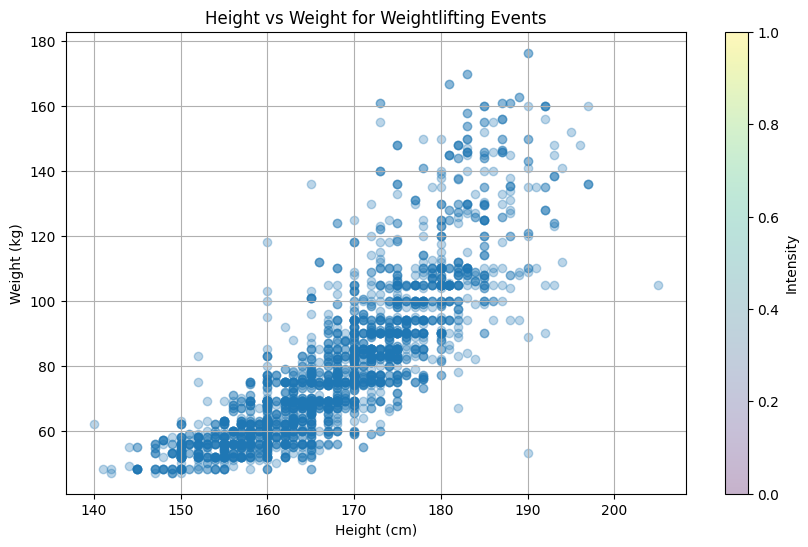

In [102]:
import matplotlib.pyplot as plt

# Filter data for weightlifting events
weightlifting_data = olympics_complete_req_data[olympics_complete_req_data['Sport'] == 'Weightlifting']

# Plot height against weight
plt.figure(figsize=(10, 6))
plt.scatter(weightlifting_data['Height'], weightlifting_data['Weight'], alpha=0.3)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.title('Height vs Weight for Weightlifting Events')
plt.grid(True)
plt.colorbar(label='Intensity')
plt.show()

In [103]:
base_data_male['target'] = np.where(base_data_male['Sport'] == 'Weightlifting', 1, 0)

In [104]:
# create the y and X matrices
from sklearn import model_selection
from sklearn import metrics
from sklearn import neighbors

Y, X = dmatrices('target ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

y = Y['target'].values

accuracies = []

kfold = model_selection.StratifiedKFold(n_splits = 5, shuffle = True).split(X, y)

model = neighbors.KNeighborsClassifier(n_neighbors = 20,
                                      p = 2,
                                      weights = 'uniform')

for train, holdout in kfold:
    model.fit(X.iloc[train], y[train])
    prediction_on_test = model.predict(X.iloc[holdout])
    accuracies.append(metrics.accuracy_score(y[holdout], prediction_on_test))

np.mean(accuracies)

0.9686902335596714

**Insight - Above accuracy shows that we can predict Weightlifting medals using hight and weight 96% accuratly**

In short description of above code:
1. If we start counting in 1964, the United States, Russia, Germany, and China have the most medals in the Olympics. They have all sent varied numbers of athletes to competitions over time and have performed better with larger contingents.
2. The years 1980 and 1984 were unusual, with the United States not participating in 1980 owing to Russia invading Afghanistan, and Russia retaliating in 1984 by not participating and initiating the friendship games.
3. We discovered intriguing insights by analyzing the most successful sporting activities in each top country, such as swimming in the USA, diving in China, wrestling in Russia, and athletics in general.
4. GDP has a favorable impact on a nation's number of medals earned!
The list of most accomplished athletes includes 50% Americans, the majority of them are swimmers!
5. Using linear regression on GDP, population, GDP_per_capita, and contingent size, we can estimate a country's medal total with an RMSE of only ~7 medals.
6. It is also possible to forecast the sports an athlete will play based solely on his height and weight. We utilized a very basic K-Nearest Neighbors model.